In [1]:
import os
import warnings
# Ignore tensorflow CUDA backend warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.filterwarnings('ignore')
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
# Path to local mavenn
sys.path.insert(0, '/grid/kinney/home/kooshkb/workspace/mavenn')
import mavenn

In [2]:
dataset = 'mpsa'
# Load example data
data_df = mavenn.load_example_dataset(dataset)

# Split dataset
trainval_df, test_df = mavenn.split_dataset(data_df)
# Preview trainval_df
print('trainval_df:')
trainval_df

Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

trainval_df:


,validation,tot_ct,ex_ct,y,x
0,False,28,2,0.023406,GGAGUGAUG
1,False,193,15,-0.074999,UUCGCGCCA
2,False,27,0,-0.438475,UAAGCUUUU
3,False,130,2,-0.631467,AUGGUCGGG
4,False,552,19,-0.433012,AGGGCAGGA
...,...,...,...,...,...
24400,False,167,1467,1.950100,GAGGUAAAU
24401,False,682,17,-0.570465,AUCGCUAGA
24402,False,190,17,-0.017078,CUGGUUGCA
24403,False,154,10,-0.140256,CGCGCACAA


In [3]:
# Length of the sequences
L = len(data_df['x'][0])
# Alphabet for RNA
alphabet = ['A', 'C', 'G', 'U']

# Default fitting kwargs
default_fit_kwargs = {
    'learning_rate': 1e-3,
    'epochs': 500,
    'batch_size': 50,
    'early_stopping': True,
    'early_stopping_patience': 30,
    'linear_initialization': False,
    'verbose': False
}

In [4]:
# Run over several GP map interaction orders
gpmap_cases = ['K1', 'K2', 'K3']
model_dict = {}

# Loop over gp-map implementations
for c, g in enumerate(gpmap_cases):
    print(g)
    if g == 'AdditiveGPMapLayer':
        gpmap = mavenn.gpmap.AdditiveGPMapLayer(L=L, alphabet=alphabet)

    if g == 'K1':
        gpmap = mavenn.gpmap.KOrderGPMap(
            L=L, alphabet=alphabet, interaction_order=1)

    if g == 'PairwiseGPMapLayer':
        gpmap = mavenn.gpmap.PairwiseGPMapLayer(
            L=L, alphabet=alphabet, mask_type='pairwise')

    if g == 'K2':
        gpmap = mavenn.gpmap.KOrderGPMap(
            L=L, alphabet=alphabet, interaction_order=2)

    if g == 'K3':
        gpmap = mavenn.gpmap.KOrderGPMap(
            L=L, alphabet=alphabet, interaction_order=3)
        
    if g == 'K4':
        gpmap = mavenn.gpmap.KOrderGPMap(
            L=L, alphabet=alphabet, interaction_order=4)

    # Initialize measurement process
    mp_GE = mavenn.measurement_process_layers.GlobalEpsitasisMP(
        K=50, ge_noise_model_type='SkewedT', ge_heteroskedasticity_order=2)
    # Define Model
    model = mavenn.Model2(gpmap=gpmap, mp_list=[mp_GE])
    # Set training data
    model.set_data(x=trainval_df['x'],
                   y_list=[trainval_df['y'].values.reshape(-1, 1)],
                   validation_flags=trainval_df['validation'],
                   shuffle=False)

    model.fit(**default_fit_kwargs)
    model_dict[f'model_K{c+1}'] = model
    # TODO: model.save is broken

K1
N = 24,405 observations set as training data.
Using 24.3% for validation.
Time to set data: 0.338 sec.


0epoch [00:00, ?epoch/s]

Training time: 245.2 seconds
K2
N = 24,405 observations set as training data.
Using 24.3% for validation.
Time to set data: 0.343 sec.


0epoch [00:00, ?epoch/s]

Training time: 616.5 seconds
K3
N = 24,405 observations set as training data.
Using 24.3% for validation.
Time to set data: 0.338 sec.


0epoch [00:00, ?epoch/s]

Training time: 235.2 seconds


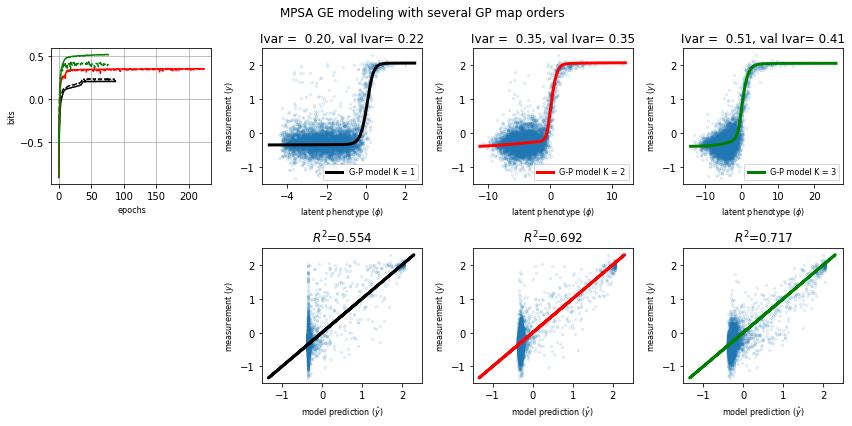

In [9]:
line_colors = ['k', 'r', 'g', 'b', 'darkorange', 'purple']
fig, axs = plt.subplots(2, len(gpmap_cases) + 1,
                        figsize=(3 * (len(gpmap_cases) + 1), 6))
for c, key in enumerate(model_dict.keys()):
    model = model_dict[key]    # Get test data y values
    y_test = test_df['y']
    # Compute phi on test data
    phi_test = model.gpmap.x_to_phi(test_df['x'])
    # Set phi lims and create a grid in phi space
    phi_lim = [min(phi_test) - .5, max(phi_test) + .5]
    phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000).astype('float32')
    mp_GE = model.mp_list[0]
    yhat_grid = mp_GE.phi_to_yhat(phi_grid)
    yhat_test = mp_GE.phi_to_yhat(phi_test)
    
    # Compute R squared
    Rsq = np.corrcoef(yhat_test.numpy().ravel(), y_test.ravel())[0, 1]**2

    # Plot GE nonlinearity
    ax = axs[0][c + 1]

    ax.scatter(phi_test, y_test, c='C10', s=5,
               alpha=0.1, zorder=-10, rasterized=True)
    ax.plot(phi_grid, yhat_grid, linewidth=3,
            color=line_colors[c], label=f'G-P model K = {c+1}')
    final_I_var = model.history['I_var'][-1]
    final_val_I_var = model.history['val_I_var'][-1]
    ax.set_title(f'Ivar = {final_I_var:5.2f}, val Ivar={final_val_I_var:5.2f}')

    # Plot training history
    ax = axs[0][0]
    # Plot I_var_train, the variational information on training data as a function of epoch
    ax.plot(model.history['I_var'], color=line_colors[c],
            label=f'train Ivar K = {c+1}')
    # Plot I_var_val, the variational information on validation data as a function of epoch
    ax.plot(model.history['val_I_var'], '--',
            color=line_colors[c], label=f'val I_var K = {c+1}')
    
    # Plot(prediction)
    ax = axs[1,c+1]
    # Plot yhat vs yhat prediction nonlinearity
    ax.scatter(yhat_test, y_test, c='C10', s=5,
               alpha=0.1, zorder=-10, rasterized=True)
    ax.plot(y_test, y_test, c=line_colors[c], linewidth=3,)
    ax.set_title(f'$R^2$={Rsq:.3}')
    
fs = 8
for c in range(len(gpmap_cases)):
    ax = axs[0][c + 1]
    ax.set_xlabel('latent phenotype ($\phi$)', fontsize=fs)
    ax.set_ylim([-1.5, 2.5])
    ax.set_ylabel('measurement ($y$)', fontsize=fs)
    ax.legend(frameon=True, loc='lower right', fontsize=fs)
    
    ax = axs[1][c + 1]
    ax.set_xlim([-1.5, 2.5])
    ax.set_ylim([-1.5, 2.5])

    ax.set_xlabel('model prediction ($\hat{y}$)', fontsize=fs)
    ax.set_ylabel('measurement ($y$)', fontsize=fs)
    
    
# Style plots
ax = axs[0][0]
ax.set_xlabel('epochs', fontsize=fs)
ax.set_ylabel('bits', fontsize=fs)
ax.grid()

fig.delaxes(axs[1][0])

plt.suptitle('MPSA GE modeling with several GP map orders')
plt.tight_layout()
plt.savefig('gp_implementations.pdf')
plt.show()